In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qibo.gates import M, X, RY, CZ, I, H
from qibo.models import Circuit
from qiboconnection.api import API
import matplotlib.pyplot as plt

from qiboconnection.connection import ConnectionConfiguration

from benchmarks.utils.qst_qpt_helper_functions import process_returned_dataformat
from time import sleep

from itertools import product
from scipy.stats import multivariate_normal
api = API(ConnectionConfiguration(username="vsanchez", api_key="ea712370-7516-4cbf-91a6-72a82e39ba02"))
from scipy import stats

api.select_device_id(9)

In [2]:
def get_chsh_circuits(bell_state, control_qubit, target_qubit, theta):
    assert bell_state in (
        "phi_plus",
        "phi_minus",
        "psi_plus",
        "psi_minus",
    ), "bell_state should be phi_plus, phi_minus, psi_plus, psi_minus"
    nqubits = max(control_qubit, target_qubit) + 1

    circuits = []
    for gate_a, gate_b in product([I, H], repeat=2):
        circuit = Circuit(nqubits)

        if bell_state == "phi_plus" or bell_state == "psi_minus":
            G1 = RY(control_qubit, theta=-np.pi / 2)
        else:
            G1 = RY(control_qubit, theta=np.pi / 2)
        if bell_state == "phi_plus" or bell_state == "phi_minus":
            G2_prime = RY(target_qubit, theta=-np.pi / 2)
        else:
            G2_prime = RY(target_qubit, theta=np.pi / 2)
        ## build bell state
        circuit.add(G1)
        circuit.add(RY(target_qubit, theta=np.pi / 2))
        circuit.add(CZ(control_qubit, target_qubit))
        circuit.add(G2_prime)

        ## decoder part
        circuit.add(RY(control_qubit, theta=theta))
        circuit.add(gate_a(control_qubit))
        circuit.add(gate_b(target_qubit))
        circuit.add(M(control_qubit, target_qubit))

        circuits.append(circuit)

    return circuits


def SPAM_circuits(control_qubit, target_qubit):
    """Circuits to get the SPAM matrix in order to perform measurement correction."""
    calibration_circuits = []
    for gate_a, gate_b in product([I, X], repeat=2):
        calibration_circuit = Circuit(5)
        calibration_circuit.add(gate_a(control_qubit))
        calibration_circuit.add(gate_b(target_qubit))
        calibration_circuit.add(M(control_qubit, target_qubit))

        calibration_circuits.append(calibration_circuit)
    return calibration_circuits


def compute_witnesses(chsh_results, measurement_calibration_weights, BELL_STATE, raw=False):
    """Returns arrays of computed witness values.

    Args:
        chsh_results (array): matrix containing the probabilities the chsh circuits. It must be
                        of dimensions len(theta_values) x 4 (decoder circuits) x 4 (probabilities)
        measurement_calibration_weights (array): measurement calibration matrix.
        BELL_STATE (string): can be "phi_plus", "phi_minus", "psi_plus" or "psi_minus". It needs
                            to be specified because the witness isn't the same for all 4 Bell states.
        raw (bool): whether or not calculate the witnesses from the raw data instead of applying the
                    measurement corrections. Defaults to False.
    Returns:
        witness1 (array): array length len(theta_values) containing the first witness
        witness2 (array): array length len(theta_values) containing the second witness
    """
    len_theta_values = np.shape(chsh_results)[0]
    witness1 = np.zeros(len_theta_values)
    witness2 = np.zeros(len_theta_values)

    if BELL_STATE in ["phi_plus", "psi_minus"]:
        signs1 = np.array([1, 1, -1, 1])
        signs2 = np.array([1, -1, 1, 1])
    else:
        signs1 = np.array([-1, 1, 1, 1])
        signs2 = np.array([1, 1, 1, -1])

    for i, chsh_result in enumerate(chsh_results):
        if raw is not True:
            # apply measurement calibration
            chsh_result = measurement_calibration_weights @ chsh_result.T
            # calculate expectation values from probabilities
            expectations = np.array([1, -1, -1, 1]).T @ chsh_result

        else:
            # calculate expectation values from probabilities
            expectations = chsh_result @ np.array([1, -1, -1, 1])
        # compute witnesses
        witness1[i] = signs1.T @ expectations
        witness2[i] = signs2.T @ expectations
    return witness1, witness2

In [3]:
CONTROL_QUBIT = 2
TARGET_QUBIT = 0
THETA_VALUES = np.linspace(-np.pi, np.pi, num=20)
BELL_STATE = "psi_minus"

NUM_SHOTS = 8000

### Build circuits for CHSH and measurement correction

In [4]:
all_circuits_chsh = []
for theta in THETA_VALUES:
    circuits_th = get_chsh_circuits(BELL_STATE, CONTROL_QUBIT, TARGET_QUBIT, theta)
    all_circuits_chsh.extend(circuits_th)

all_circuits = SPAM_circuits(CONTROL_QUBIT, TARGET_QUBIT)

all_circuits.extend(all_circuits_chsh)

### Run circuits

In [5]:
# result_id = api.execute(all_circuits, nshots=NUM_SHOTS)[0]
result_id = 8695

In [6]:
# results = None
# while results is None:
#     results = api.get_result(result_id)
#     sleep(30)
# results

### Process real data

In [7]:
## retrieve data
results = api.get_result(result_id)
data_probabilities = process_returned_dataformat(results, nqubits=2)

## measurement calibration data processing
spam_data_probabilities = data_probabilities[:4]
measurement_calibration_weights = np.linalg.inv(spam_data_probabilities)

## chsh circuits data processing
chsh_data_probabilities = data_probabilities[4:]
chsh_data_probabilities_theta = chsh_data_probabilities.reshape(len(THETA_VALUES), 4, 4)


## compute witness
w1_raw, w2_raw = compute_witnesses(chsh_data_probabilities_theta, measurement_calibration_weights, BELL_STATE, raw=True)
w1_corrected, w2_corrected = compute_witnesses(
    chsh_data_probabilities_theta, measurement_calibration_weights, BELL_STATE, raw=False
)

Your job with id 8695 is completed.


### Run simulation, get ideal witnesses

In [8]:
circ_list = SPAM_circuits(0, 1)
ideal_results_spam = np.zeros((len(circ_list), 4))
for i, c in enumerate(circ_list):
    ideal_results_spam[i] += c.execute().probabilities()
ideal_measurement_calibration_weights = np.linalg.inv(ideal_results_spam)

circ_list = list(np.copy(all_circuits_chsh))
ideal_results_chsh = np.zeros((len(circ_list), 4))
for i, c in enumerate(circ_list):
    ideal_results_chsh[i] += c.execute().probabilities()

ideal_results_chsh_theta = ideal_results_chsh.reshape(len(THETA_VALUES), 4, 4)

w1_ideal, w2_ideal = compute_witnesses(
    ideal_results_chsh_theta, ideal_measurement_calibration_weights, BELL_STATE, raw=False
)

[Qibo 0.1.12.dev0|INFO|2024-02-29 16:06:52]: Using numpy backend on /CPU:0


### Get error bars

In [9]:
stats.binom.rvs(stats.multinomial.rvs(NUM_SHOTS, data_probabilities[i])[0], 0.2)

643

In [10]:
e0 = 0.8 # fidelity 0 readout
e1 = 0.8 # fidelity 1 readout
e_m = np.array([[e0, e0*(1-e0), e0*(1-e0), (1-e0)**2],
                [e0*(1-e1),e1*e0,(1-e1)*(1-e0),e1*(1-e0)],
                [e0*(1-e1),(1-e1)*(1-e0),e1*e0,e1*(1-e0)],
                [(1-e1)**2,e1*(1-e0),e1*(1-e0),e1**2]
                ])

np.array([1,0,0,0]) @ e_m

array([0.8 , 0.16, 0.16, 0.04])

In [11]:
stats.multinomial.rvs(NUM_SHOTS, data_probabilities[i]) @ e_m

array([2960.44, 1677.8 , 1658.  , 2205.2 ])

In [12]:
def return_mock_results(data_probabilities, e0=1, e1=1):
    # returns simulated results using distribution from experimental results' probabilities
    mock_results = np.empty(shape=data_probabilities.shape)
    # measurement_calibration_weights = np.linalg.inv(data_probabilities[:4])

    e_m = np.array([[e0**2, e0*(1-e0), e0*(1-e0), (1-e0)**2],
                    [e0*(1-e1),e1*e0,(1-e1)*(1-e0),e1*(1-e0)],
                    [e0*(1-e1),(1-e1)*(1-e0),e1*e0,e1*(1-e0)],
                    [(1-e1)**2,e1*(1-e0),e1*(1-e0),e1**2]])
    
    for i, _ in enumerate(mock_results):    
        mock_results[i] = (stats.multinomial.rvs(NUM_SHOTS, data_probabilities[i]) / NUM_SHOTS) @ e_m

    measurement_calibration_weights = np.linalg.inv(data_probabilities[:4])
    mock_results = mock_results[4:]


    return list((compute_witnesses(mock_results.reshape(-1, 4, 4), measurement_calibration_weights, BELL_STATE, raw=False) +
            compute_witnesses(mock_results.reshape(-1, 4, 4), measurement_calibration_weights, BELL_STATE, raw=True)))
    
def get_err_bars(mock_results):
    data_hist = np.stack(mock_results)
    err_bars = np.empty(len(data_hist.T))
    for i, hist in enumerate(data_hist.T):
        _ , var = stats.norm.fit(hist)
        err_bars[i] =np.sqrt(var)
    return err_bars

# generate n copies of random results
err_w1, err_w2, err_w1_unc, err_w2_unc  = [get_err_bars(mock_results) for mock_results in zip(*[return_mock_results(data_probabilities) for _ in range(800)])]

### Plot results

(array([ 1.,  0.,  3.,  0.,  1.,  6.,  4.,  4.,  6.,  4.,  8., 11., 16.,
        26., 21., 31., 33., 38., 40., 48., 46., 56., 46., 56., 49., 47.,
        39., 52., 46., 44., 37., 33., 22., 22., 17., 18., 20., 10., 12.,
         5.,  6.,  3.,  6.,  4.,  1.,  0.,  0.,  1.,  0.,  1.]),
 array([0.87002345, 0.87212179, 0.87422013, 0.87631847, 0.87841681,
        0.88051515, 0.88261349, 0.88471183, 0.88681017, 0.88890851,
        0.89100686, 0.8931052 , 0.89520354, 0.89730188, 0.89940022,
        0.90149856, 0.9035969 , 0.90569524, 0.90779358, 0.90989192,
        0.91199026, 0.9140886 , 0.91618694, 0.91828529, 0.92038363,
        0.92248197, 0.92458031, 0.92667865, 0.92877699, 0.93087533,
        0.93297367, 0.93507201, 0.93717035, 0.93926869, 0.94136703,
        0.94346537, 0.94556372, 0.94766206, 0.9497604 , 0.95185874,
        0.95395708, 0.95605542, 0.95815376, 0.9602521 , 0.96235044,
        0.96444878, 0.96654712, 0.96864546, 0.9707438 , 0.97284215,
        0.97494049]),
 <BarContainer

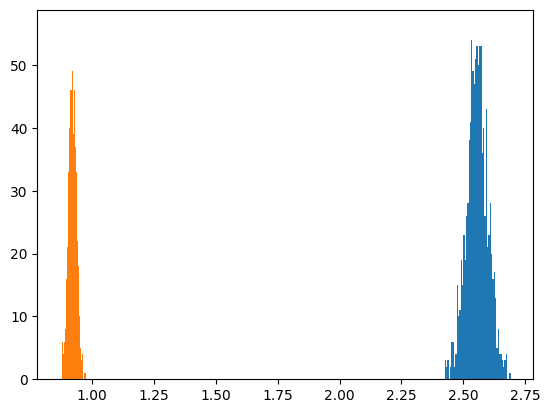

In [13]:
plt.hist(np.array([return_mock_results(data_probabilities)[0][0] for _ in range(1000)]), bins=50)
plt.hist(np.array([return_mock_results(data_probabilities, e0=0.8, e1=0.8)[0][0] for _ in range(1000)]), bins=50)


In [14]:
a0= [err_w1, err_w2, err_w1_unc, err_w2_unc]

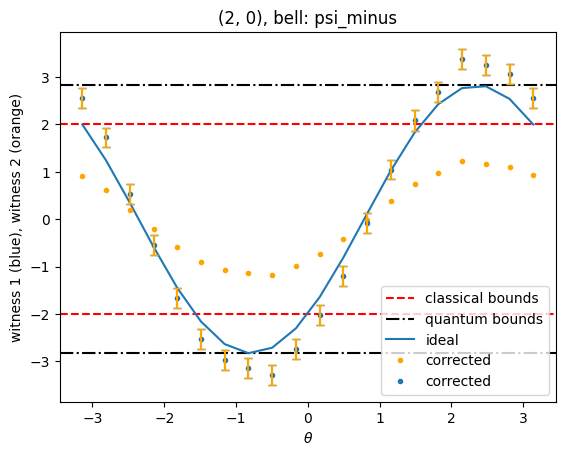

In [15]:
fname = f"chsh_{CONTROL_QUBIT}_{TARGET_QUBIT}_{BELL_STATE}_nshots{NUM_SHOTS}_jobid{result_id}.png"
savefig = False

fig, ax = plt.subplots()
ax.axhline(2, color="red", linestyle="--", label="classical bounds")
ax.axhline(-2, color="red", linestyle="--")
ax.axhline(2 * np.sqrt(2), color="k", linestyle="-.", label="quantum bounds")
ax.axhline(-2 * np.sqrt(2), color="k", linestyle="-.")

ax.plot(THETA_VALUES, w1_ideal, label="ideal")
# ax.plot(THETA_VALUES, w2_ideal)

# ax.plot(THETA_VALUES, w1_raw, "x", ms=3, c="C0", label="raw")
# ax.errorbar(THETA_VALUES, w1_raw, err_w1_unc, capsize=3, c="C0", ls="none")

# ax.plot(THETA_VALUES, w2_raw, "x", ms=3, c="C1")
# ax.errorbar(THETA_VALUES, w2_raw, err_w2_unc, capsize=3, c="C1", ls="none")

ax.plot(THETA_VALUES, np.mean([return_mock_results(data_probabilities, e0=0.8, e1=0.8)[0] for _ in range(200)], axis=0), ".", c="orange", label="corrected")

ax.plot(THETA_VALUES, w1_corrected, ".", c="C0", label="corrected")
ax.errorbar(THETA_VALUES, w1_corrected, err_w1, capsize=3, c="C0", ls="none")
ax.errorbar(THETA_VALUES, w1_corrected, a0[0], capsize=3, c="orange", ls="none")



# ax.plot(THETA_VALUES, w2_corrected, ".", c="C1")
# ax.errorbar(THETA_VALUES, w2_corrected, err_w2, capsize=3, c="C1", ls="none")

ax.legend()

ax.set_xlabel("$\\theta$")
ax.set_ylabel("witness 1 (blue), witness 2 (orange)")

ax.set_title(f"({CONTROL_QUBIT}, {TARGET_QUBIT}), bell: {BELL_STATE}")
if savefig:
    fig.savefig(fname, bbox_inches="tight")